# Partie 2 : Comparaison des embeddings visuels

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
from pathlib import Path

c:\Users\victor\Documents\ECOLE\5A\T1\BIG DATA\PROJET\PROJET 2\chanel-recommender\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("DBQ/Chanel.Product.prices.Germany")
df = ds["train"].to_pandas()

df = df[df["title"] != "n.a."]

image_dir = Path("../data/images")

df["has_image"] = df.index.map(lambda i: (image_dir / f"{i}.jpg").exists())
df = df[df["has_image"]]

df["image_id"] = df.index
df = df.reset_index(drop=True)

# Filtrer classes qui ont au moins 5 images
counts = df["category2_code"].value_counts()
valid_classes = counts[counts >= 5].index
df = df[df["category2_code"].isin(valid_classes)]

print("Taille du dataset nettoyé :", df.shape)



Taille du dataset nettoyé : (868, 19)


# Chargement des images

In [3]:
IMG_SIZE = (224, 224)

def load_image(id):
    path = f"../data/images/{id}.jpg"
    img = load_img(path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = img / 255.0
    return img

X = np.array([load_image(i) for i in df["image_id"]])
print("Shape X:", X.shape)

Shape X: (868, 224, 224, 3)


# Encodage des labels

In [4]:
le = LabelEncoder()
y = le.fit_transform(df["category2_code"])
y = keras.utils.to_categorical(y)

nb_classes = y.shape[1]
input_shape = (224, 224, 3)

print("Nombre de classes =", nb_classes)

Nombre de classes = 26


## CNN

In [5]:
inputs = keras.Input(shape=input_shape)

x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.4)(x)

embedding_layer = keras.layers.Dense(128, activation="relu", name="embedding")(x)
x = keras.layers.Dropout(0.3)(embedding_layer)

outputs = keras.layers.Dense(nb_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,819,866 (98.49 MB)

 Trainable params: 25,819,866 (98.49 MB)

 Non-trainable params: 0 (0.00 B)

## Split 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)

(607, 224, 224, 3) (130, 224, 224, 3) (131, 224, 224, 3)


# Training

In [7]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 576ms/step - accuracy: 0.2158 - loss: 3.3614 - val_accuracy: 0.3846 - val_loss: 2.6088
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 597ms/step - accuracy: 0.3624 - loss: 2.4472 - val_accuracy: 0.4462 - val_loss: 2.2139
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 597ms/step - accuracy: 0.4596 - loss: 1.9653 - val_accuracy: 0.5385 - val_loss: 1.7381
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.5453 - loss: 1.6269 - val_accuracy: 0.6000 - val_loss: 1.5338
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step - accuracy: 0.6063 - loss: 1.4625 - val_accuracy: 0.5769 - val_loss: 1.4511
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 578ms/step - accuracy: 0.6310 - loss: 1.2704 - val_accuracy: 0.6538 - val_loss: 1.2760
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 572ms/step - accuracy: 0.6969 - loss: 0.9921 - val_accuracy: 0.7231 - val_loss: 1.0969
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.7430 - loss: 0.8798 - val_accur

# Évaluation du modèle

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy = {test_acc:.4f}")
print(f"Test loss      = {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7099 - loss: 1.1994
Test accuracy = 0.7099
Test loss      = 1.1994


# Extraction Embeddings

In [9]:
embed_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer("embedding").output
)

embeddings_cnn = embed_model.predict(X)
print("Shape embeddings CNN:", embeddings_cnn.shape)

np.save("../data/embeddings_cnn.npy", embeddings_cnn)

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step
Shape embeddings CNN: (868, 128)


# Chargement du modèle CLIP

In [10]:
import torch
import clip
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

clip_model, preprocess = clip.load("ViT-B/32", device=device)

Device: cpu


In [11]:
image_dir = Path("../data/images")

def load_clip_image(id):
    path = image_dir / f"{id}.jpg"
    try:
        img = Image.open(path).convert("RGB")
        return preprocess(img).unsqueeze(0).to(device)
    except:
        return None

# Extraction embeddings CLIP

In [ ]:
embeddings_clip = []

with torch.no_grad():
    for img_id in tqdm(df["image_id"], desc="CLIP embeddings"):
        
        img_tensor = load_clip_image(img_id)
        
        if img_tensor is None:
            embeddings_clip.append(np.zeros(512)) 
            continue

        emb = clip_model.encode_image(img_tensor)
        emb = emb / emb.norm(dim=-1, keepdim=True)   
        embeddings_clip.append(emb.cpu().numpy()[0])

embeddings_clip = np.vstack(embeddings_clip)
print("Shape embeddings CLIP :", embeddings_clip.shape)

# Sauvegarde
np.save("../data/embeddings_clip.npy", embeddings_clip)

CLIP embeddings: 100%|██████████| 868/868 [00:58<00:00, 14.79it/s]

Shape embeddings CLIP : (868, 512)


# Chargement des embeddings

In [13]:
import numpy as np

emb_cnn = np.load("../data/embeddings_cnn.npy")       
emb_clip = np.load("../data/embeddings_clip.npy")     

# Fonctions de distance

In [14]:
from numpy.linalg import norm

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (norm(a) * norm(b) + 1e-8)


# Cohérence intra-classe / inter-classe

In [15]:
import random

def class_distances(embeddings, df):
    classes = df["category2_code"].unique()
    intra = []
    inter = []

    for c in classes:
        idx = df[df["category2_code"] == c].index.tolist()
        if len(idx) < 2:
            continue

        # intra-classe : moyenne des distances entre paires
        for i in range(len(idx)-1):
            for j in range(i+1, len(idx)):
                intra.append(cosine_distance(embeddings[idx[i]], embeddings[idx[j]]))

        # inter-classe : comparer avec 3 classes aléatoires
        other_classes = [x for x in classes if x != c]
        random_other = random.sample(list(other_classes), k=min(3, len(other_classes)))

        for oc in random_other:
            idx2 = df[df["category2_code"] == oc].index.tolist()
            for i in idx[:3]:
                for j in idx2[:3]:
                    inter.append(cosine_distance(embeddings[i], embeddings[j]))

    return np.mean(intra), np.mean(inter)

df = df.reset_index(drop=True)

cnn_intra, cnn_inter = class_distances(emb_cnn, df)
clip_intra, clip_inter = class_distances(emb_clip, df)

print("CNN :", cnn_intra, cnn_inter)
print("CLIP :", clip_intra, clip_inter)


CNN : 0.08934677 0.65233386
CLIP : 0.20221075 0.3622225


# Distances entre 3 produits 

In [21]:
def pick_example(df, keywords):
    for kw in keywords:
        matches = df[df["title"].str.contains(kw, case=False, na=False)]
        if len(matches) > 0:
            return matches.index[0]
    return None

# Choix des exemples représentatifs
idx_bag = pick_example(df, ["Leder", "Lammleder", "Kalbsleder", "Vintage"])
idx_glasses = pick_example(df, ["Gläser", "Polarisiert", "Transparent", "Verlauf"])
idx_jewelry = pick_example(df, ["Karat", "Gold", "Diamant", "Kristall"])

print("Bag       :", idx_bag, df.loc[idx_bag, "title"])
print("Glasses   :", idx_glasses, df.loc[idx_glasses, "title"])
print("Jewelry   :", idx_jewelry, df.loc[idx_jewelry, "title"])


Bag       : 13 Geknautschtes Lammlackleder  Schwarz
Glasses   : 2 Silberfarben. Gläser: Braun  Mit Verlauf
Jewelry   : 7 Steppmotiv  kleines Modell  18 Karat Gelbgold  Diamanten


In [23]:
pairs = [
    ("Bag vs Glasses", idx_bag, idx_glasses),
    ("Bag vs Jewelry", idx_bag, idx_jewelry),
    ("Glasses vs Jewelry", idx_glasses, idx_jewelry),
]

def compare_examples(name, i, j):
    print(f"\n### {name}")
    print("CNN  :", cosine_distance(emb_cnn[i], emb_cnn[j]))
    print("CLIP :", cosine_distance(emb_clip[i], emb_clip[j]))

for name, i, j in pairs:
    compare_examples(name, i, j)




### Bag vs Glasses
CNN  : 0.33130348
CLIP : 0.23285097

### Bag vs Jewelry
CNN  : 0.7521453
CLIP : 0.43312943

### Glasses vs Jewelry
CNN  : 0.80212927
CLIP : 0.37889516


# Comparaison TSNE

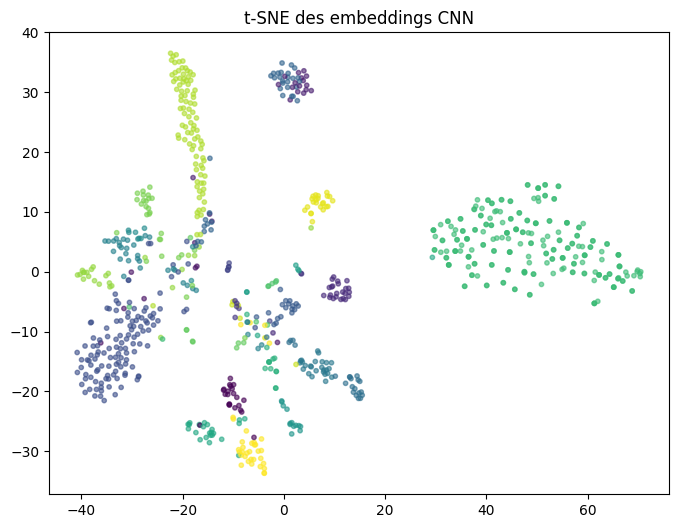

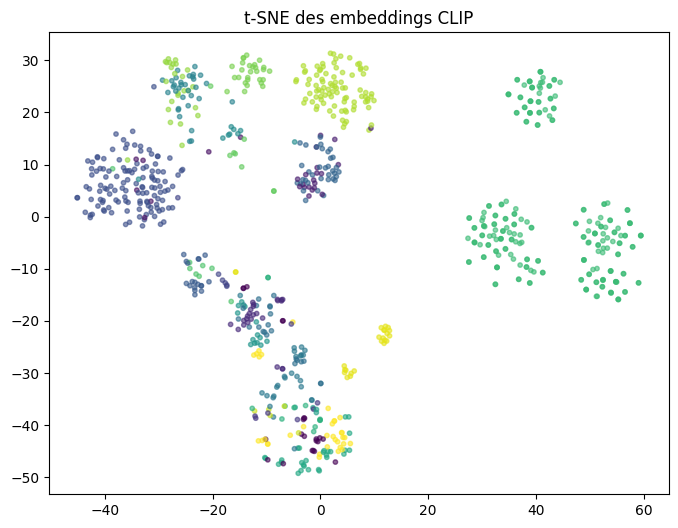

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(embeddings, df, title):
    tsne = TSNE(n_components=2, random_state=42)
    E2D = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(E2D[:,0], E2D[:,1], c=df["category2_code"].astype('category').cat.codes, s=10, alpha=0.6)
    plt.title(title)
    plt.show()

tsne_plot(emb_cnn, df, "t-SNE des embeddings CNN")
tsne_plot(emb_clip, df, "t-SNE des embeddings CLIP")
